## Chris's KFold + Different Inputs Ensemble

#### Ideas implemented here:
* [X] 5-fold train using [Chris Deotte's CV Strategy](https://www.kaggle.com/c/lish-moa/discussion/195195)
* [X] Blend best 2 models per fold
* [X] Train separate Neural Networks for inputs into `Categorical`, `Genes`, and `Cells` respectively
* [X] Train these networks End-to-End

#### Architecture:
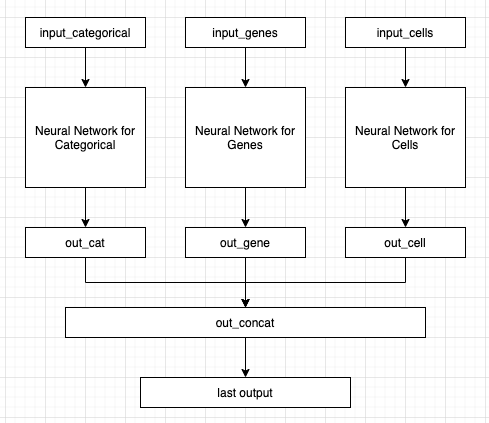
#### References:
* [namanj27's popular PyTorch Notebook](https://www.kaggle.com/namanj27/new-baseline-pytorch-moa)
* [Chris Deotte's CV Strategy](https://www.kaggle.com/c/lish-moa/discussion/195195)

### If the notebook helps you, **Please UPVOTE!**

In [ ]:
import os
import sys
import copy
import random

from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("torch version:", torch.__version__)

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## Data Access + Preprocessing 

In [ ]:
ROOT = "../input/lish-moa"

In [ ]:
df_train_features          = pd.read_csv(f'{ROOT}/train_features.csv')
df_train_targets_scored    = pd.read_csv(f'{ROOT}/train_targets_scored.csv')
df_train_targets_nonscored = pd.read_csv(f'{ROOT}/train_targets_nonscored.csv')
df_train_drug              = pd.read_csv(f'{ROOT}/train_drug.csv')
df_test_features           = pd.read_csv(f'{ROOT}/test_features.csv')
df_sample_submission       = pd.read_csv(f'{ROOT}/sample_submission.csv')

In [ ]:
print("Train shapes:", df_train_features.shape, df_train_targets_scored.shape, df_train_drug.shape, df_train_targets_nonscored.shape)
print("Test shapes: ", df_test_features.shape, df_sample_submission.shape)

In [ ]:
col_genes   = [col for col in df_train_features.columns.to_list() if col[:2] == "g-"]
col_cells   = [col for col in df_train_features.columns.to_list() if col[:2] == "c-"]
col_cats    = ["cp_time", "cp_dose"]

col_targets = df_train_targets_scored.columns.to_list()[1:]

print("-"*25)
print("Number of Gene columns:       ", len(col_genes))
print("Number of Cell columns:       ", len(col_cells))
print("Number of Categorical columns:", len(col_cats))
print("-"*25)
print("Number of Target columns:     ", len(col_targets))
print("-"*25)

In [ ]:
print("Data explore:")
print("-"*25)
print("Number of unique in sig_id:  %5d" % df_train_features.sig_id.unique().shape[0], "| Examples:",  df_train_features.sig_id.unique()[:3])
print("Number of unique in cp_type: %5d" % df_train_features.cp_type.unique().shape[0], "| Examples:",  df_train_features.cp_type.unique()[:3])
print("Number of unique in cp_time: %5d" % df_train_features.cp_time.unique().shape[0], "| Examples:",  df_train_features.cp_time.unique()[:3])
print("Number of unique in cp_dose: %5d" % df_train_features.cp_dose.unique().shape[0], "| Examples:",  df_train_features.cp_dose.unique()[:3])

print("-"*25)
print("Most frequent targets:")
print("-"*25)
df_train_targets_scored.sum()[1:].sort_values(ascending=False)

In [ ]:
df_train = df_train_features.merge(df_train_targets_scored, how="left", on="sig_id")
df_train = df_train.merge(df_train_drug, on="sig_id", how="left")
df_train = df_train.dropna()

df_test = df_test_features.copy()

print(df_train.shape)
print(df_test.shape)
df_train.head(2)

## Split Folds

In [ ]:
### FOLD 
NFOLDS = 5
SEED = 42

# DELETE FOLD COLUMN
if "fold" in df_train.columns: del df_train['fold']

vc = df_train.drug_id.value_counts()
vc1 = vc.loc[vc<=18].index.sort_values()
vc2 = vc.loc[vc>18].index.sort_values()

# STRATIFY DRUGS 18X OR LESS
dct1 = {}; dct2 = {}
skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
tmp = df_train.groupby('drug_id')[col_targets].mean().loc[vc1]
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[col_targets])):
    dd = {k:fold for k in tmp.index[idxV].values}
    dct1.update(dd)

# STRATIFY DRUGS MORE THAN 18X
skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
tmp = df_train.loc[df_train.drug_id.isin(vc2)].reset_index(drop=True)
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[col_targets])):
    dd = {k:fold for k in tmp.sig_id[idxV].values}
    dct2.update(dd)

# ASSIGN FOLDS
df_train['fold'] = df_train.drug_id.map(dct1)
df_train.loc[df_train.fold.isna(),'fold'] =\
    df_train.loc[df_train.fold.isna(),'sig_id'].map(dct2)
df_train.fold = df_train.fold.astype('int8')

In [ ]:
print("Sum of `Ctl_vehicle` is %d. Meaning targets are zeroes. So that's why we can ignore these data." % df_train[df_train.cp_type=="ctl_vehicle"][col_targets].sum().sum())
print("Sum of `Trt_cp` is %d. So we are using these columns." % df_train[df_train.cp_type=="trt_cp"][col_targets].sum().sum())

print("Before excluding `ctl_vehicle`: ", df_train.shape)
df_train = df_train.loc[df_train.cp_type=="trt_cp"]
df_train = df_train.reset_index(drop=True)
print("After excluding `ctl_vehicle`: ", df_train.shape)

In [ ]:
sns.countplot(df_train["fold"])
plt.title("Fold Count Plot")
plt.show()

In [ ]:
# convert categorical data
df_train.loc[:, 'cp_dose'] = df_train.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
df_test .loc[:, 'cp_dose'] = df_test .loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# getting all input columns
col_input = col_cats + col_cells + col_genes

In [ ]:
print("####### FINAL FEATURES ###########")
print("Number of Total Input features: ", len(col_input))
print("Number of Categorical features: ", len(col_cats))
print("Number of Genes features:       ", len(col_cells))
print("Number of Cells features:       ", len(col_genes))
print("Number of Target features:      ", len(col_targets))

print("Train data shape:", df_train[col_input].shape)
print("Test  data shape: ", df_test [col_input].shape)

In [ ]:
class MoADataset:
    def __init__(self, features_cat, features_gene, features_cell, targets):
        self.features_cat  = features_cat
        self.features_gene = features_gene
        self.features_cell = features_cell
        self.targets = targets
        
    def __len__(self):
        return (self.features_cat.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x1' : torch.tensor(self.features_cat[idx, :], dtype=torch.float),
            'x2' : torch.tensor(self.features_gene[idx, :], dtype=torch.float),
            'x3' : torch.tensor(self.features_cell[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features_cat, features_gene, features_cell):
        self.features_cat  = features_cat
        self.features_gene = features_gene
        self.features_cell = features_cell
        
    def __len__(self):
        return (self.features_cat.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x1' : torch.tensor(self.features_cat[idx, :], dtype=torch.float),
            'x2' : torch.tensor(self.features_gene[idx, :], dtype=torch.float),
            'x3' : torch.tensor(self.features_cell[idx, :], dtype=torch.float),
        }
        return dct

## Train Utils


In [ ]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        input1, input2, input3, targets = data['x1'].to(device), data['x2'].to(device), data['x3'].to(device), data['y'].to(device)

        outputs = model(input1, input2, input3)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        if scheduler: scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        input1, input2, input3, targets = data['x1'].to(device), data['x2'].to(device), data['x3'].to(device), data['y'].to(device)
        outputs = model(input1, input2, input3)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        input1, input2, input3 = data['x1'].to(device), data['x2'].to(device), data['x3'].to(device)

        with torch.no_grad():
            outputs = model(input1, input2, input3)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [ ]:
# competition metric
def logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)).mean()

## Modeling

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features_cat, num_features_gene, num_features_cell, num_targets, hidden_size, dropout_rate=0.5, activation=F.relu):
        super(Model, self).__init__()
        
        def get_sequential_layers(num_features, n_layers, hidden_size, dropout_rate):
            layer_list = []
            in_ = num_features

            for i in range(n_layers):
                layer_list.append(
                    torch.nn.Sequential
                    (
                        torch.nn.BatchNorm1d(in_),
                        torch.nn.Dropout(dropout_rate),
                        torch.nn.Linear(in_, hidden_size),
                    )
                )
                in_ = hidden_size

            return layer_list

        self.layer_list_cat  = torch.nn.ModuleList(get_sequential_layers(num_features_cat , 2, hidden_size, dropout_rate))
        self.layer_list_gene = torch.nn.ModuleList(get_sequential_layers(num_features_gene, 4, hidden_size, dropout_rate))
        self.layer_list_cell = torch.nn.ModuleList(get_sequential_layers(num_features_cell, 3, hidden_size, dropout_rate))

        self.activation = activation
        
        self.batch_norm_out = nn.BatchNorm1d(hidden_size*3)
        self.dropout_out = nn.Dropout(dropout_rate)
        self.dense_out = nn.Linear(hidden_size*3, num_targets)
    
    def forward(self, x1, x2, x3):

        for batchnorm, dropout, linear in self.layer_list_cat:
            x1 = batchnorm(x1)
            x1 = dropout(x1)
            x1 = linear(x1)
            x1 = self.activation(x1)

        for batchnorm, dropout, linear in self.layer_list_gene:
            x2 = batchnorm(x2)
            x2 = dropout(x2)
            x2 = linear(x2)
            x2 = self.activation(x2)

        for batchnorm, dropout, linear in self.layer_list_cell:
            x3 = batchnorm(x3)
            x3 = dropout(x3)
            x3 = linear(x3)
            x3 = self.activation(x3)
        
        # print(x1.size(), x2.size(), x3.size())

        x = torch.cat([x1, x2, x3], dim=-1)
        # print(x.size())

        x = self.batch_norm_out(x)
        x = self.dropout_out(x)
        x = self.dense_out(x)
        
        return x

## Train utils

In [ ]:
def run_training(fold, seed, PARAMS, df_train, DEVICE):
    
    seed_everything(seed)

    train_ = df_train.copy()
    
    trn_idx = train_[train_['fold'] != fold].index
    val_idx = train_[train_['fold'] == fold].index
    
    train_df = train_[train_['fold'] != fold].reset_index(drop=True)
    valid_df = train_[train_['fold'] == fold].reset_index(drop=True)
    
    x_train_cat, x_train_gene, x_train_cell, y_train  = train_df[col_cats].values, train_df[col_genes].values, train_df[col_cells].values, train_df[col_targets].values
    x_valid_cat, x_valid_gene, x_valid_cell, y_valid  = valid_df[col_cats].values, valid_df[col_genes].values, valid_df[col_cells].values, valid_df[col_targets].values
    
    train_dataset = MoADataset(x_train_cat, x_train_gene, x_train_cell, y_train)
    valid_dataset = MoADataset(x_valid_cat, x_valid_gene, x_valid_cell, y_valid)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, drop_last=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=False)
    
    model = Model(
        num_features_cat=len(col_cats),
        num_features_gene=len(col_genes),
        num_features_cell=len(col_cells),
        num_targets=len(col_targets),
        hidden_size=PARAMS["hidden_size"],
        dropout_rate=PARAMS["dropout_rate"],
        activation=PARAMS["activation"],
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["LEARNING_RATE"], weight_decay=PARAMS["WEIGHT_DECAY"])
    scheduler = None
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    best_loss = np.inf
    
    #--------------------- TRAIN ---------------------
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        
        if VERBOSE and epoch % VERBOSE == 0:
            print(f"FOLD: %d, EPOCH: %3d | train_loss: %.5f | valid_loss: %.5f"%(fold,epoch,train_loss,valid_loss))
        
        if valid_loss < best_loss:
            
            if epoch > 1:
                os.rename(f"SEED_{seed}_FOLD{fold}_0.pth", f"SEED_{seed}_FOLD{fold}_1.pth")
            best_loss = valid_loss
            torch.save(model.state_dict(), f"SEED_{seed}_FOLD{fold}_0.pth")
            early_step = 0
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= EARLY_STOPPING_STEPS):
                break
    
            
    #--------------------- PREDICTION---------------------
    x_test_cat, x_test_gene, x_test_cell = df_test[col_cats].values, df_test[col_genes].values, df_test[col_cells].values
    testdataset = TestDataset(x_test_cat, x_test_gene, x_test_cell)
    
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=False)
    
    oof         = np.zeros((df_train.shape[0], len(col_targets)))
    predictions = np.zeros((df_test.shape[0], len(col_targets)))

    for nb in range(NBEST):
        model = Model(
            num_features_cat=len(col_cats),
            num_features_gene=len(col_genes),
            num_features_cell=len(col_cells),
            num_targets=len(col_targets),
            hidden_size=PARAMS["hidden_size"],
            dropout_rate=PARAMS["dropout_rate"],
            activation=PARAMS["activation"],
        )

        model_path = f"SEED_{seed}_FOLD{fold}_{nb}.pth"

        if not os.path.isfile(model_path):
            continue

        model.load_state_dict(torch.load(model_path))
        model.to(DEVICE)

        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        
        oof[val_idx] += valid_preds / NBEST
        predictions += inference_fn(model, testloader, DEVICE) / NBEST

    score = logloss(y_valid, oof[val_idx])
    print("FOLD: %d, Log Loss: %.5f"%(fold, score))
    print("-"*15)
    return oof, predictions, score


In [ ]:
def run_k_fold(NFOLDS, seed, PARAMS, df_train, DEVICE):

    oof         = np.zeros((df_train.shape[0], len(col_targets)))
    predictions = np.zeros((df_test.shape[0], len(col_targets)))
    scores      = []
    
    for fold in range(NFOLDS):
        torch.cuda.empty_cache()
        oof_, pred_, score_ = run_training(fold, seed, PARAMS, df_train, DEVICE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
        scores.append(score_)
        
    return oof, predictions, scores


## Train

In [ ]:
# Selected parameter for training

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS               = 101
EARLY_STOPPING_STEPS = 30
EARLY_STOP           = True

NFOLDS               = 5
VERBOSE              = 10
NBEST                = 2
SEED                 = 42

PARAMS = {
    'BATCH_SIZE':    256, 
    'LEARNING_RATE': 1e-2,
    'WEIGHT_DECAY':  1e-6, 
    'hidden_size':   512, 
    'dropout_rate':  0.4, 
    'activation':    F.relu,
}

In [ ]:
oof         = np.zeros((df_train.shape[0], len(col_targets)))
predictions = np.zeros((df_test.shape[0], len(col_targets)))

st = time()
oof, predictions, scores_ = run_k_fold(NFOLDS, SEED, PARAMS, df_train, DEVICE)
score_oof = logloss(df_train[col_targets].values, oof)
print("-"*15)
print("STD: %.6f | OOF: %6f | CV: %6f | done in %.1f min"%(np.std(scores_), np.mean(scores_), score_oof, (time() - st)/60))

df_test[col_targets] = predictions

## Submit

In [ ]:
df_test.loc[df_test.cp_type == "ctl_vehicle", col_targets] = 0
df_test[["sig_id"] + col_targets].to_csv("submission.csv", index=False)